# 타이타닉 튜토리얼 2 - Exploratory data analysis, visualization, machine learning

참고 - https://kaggle-kr.tistory.com/18?category=868316

# 1회차 

In [123]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

In [124]:
plt.style.use('seaborn')
sns.set(font_scale=2.5)

In [125]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [126]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

In [127]:
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()
df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

# 3. Feature engineering

가장 먼저 데이터셋에 존재하는 null data를 채우려고 합니다.

아무 숫자로 채울 수 없고, null data를 포함하는 피처의 statistics를 참고하거나, 다른 아이디어로 채울 수 있습니다.

null data를 어떻게 채우느냐에 따라 모델의 성능이 달라지기 때문에, 신경써야 합니다.

fearture engineering은 실제 모델의 학습에 쓰려고 하는 것이므로, 훈련용뿐만 아니라 검증용도 똑같이 적용해야 합니다.

## 3.1 Fill Null

### 3.1.1 Fill Null in Age using title 

Age 에는 null data가 177개나 있습니다. 이를 채울 수 있는 여러 아이디어가 있을 것인데, 우리는 title + statistics를 사용해보겠습니다.

영어에는 Ms, Mr, Mrs 같은 title이 존재합니다. 각 탑승객의 이름에는 꼭 이런 title이 들어가게 되는데 이를 사용해보겠습니다.

pandas series에는 data를 string으로 바꿔주는 str 메서드, 거기에 정규표현식을 적용하게 해주는 extract 메서드가 있습니다. 이를 사용하여 title을 쉽게 추출할 수 있습니다. title을 initial column에 저장하겠습니다.

In [128]:
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')

pandas의 crosstab을 이용하여 우리가 추출한 Initial과 Sex간의 count을 살펴봅시다.

In [129]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


위 테이블을 참고하여 남자 여자가 쓰는 initial을 구분해 보겠습니다. replace 메서드를 사용하면, 특정 데이터 값을 원하는 값으로 치환해줍니다.

In [130]:
df_train['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don', 'Dona'], ['Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other', 'Other', 'Other', 'Mr', 'Mr', 'Mr', 'Mr'], inplace=True)

In [133]:
df_test['Initial'].replace(['Mlle', 'Mme', 'Ms', 'Dr', 'Major', 'Lady', 'Countess', 'Jonkheer', 'Col', 'Rev', 'Capt', 'Sir', 'Don', 'Dona'], ['Miss', 'Miss', 'Miss', 'Mr', 'Mr', 'Mrs', 'Mrs', 'Other', 'Other', 'Other', 'Mr', 'Mr', 'Mr', 'Mr'], inplace=True)

In [135]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


여성과 관계있는 Miss, Mr, Mrs가 생존률이 높은 것을 볼 수 있습니다.

<AxesSubplot:xlabel='Initial'>

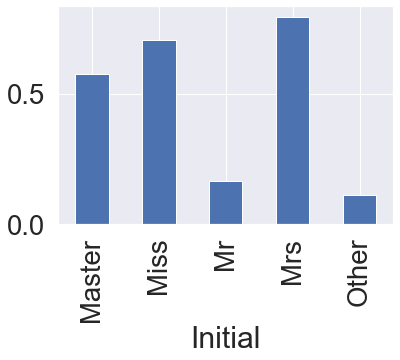

In [136]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

이제 본격적으로 Null을 채울 것입니다. null data을 채우는 방법은 정말 많이 존재합니다. statistics을 활용하는 방법도 있고, null data가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있습니다. 여기서는 statistics를 활용하는 방법을 사용할 것입니다.

여기서 statistics는 train data의 것을 의미합니다. 우리는 언제나 test을 unseen으로 둔 상태로 놔둬야 하며, train에서 얻은 statistics를 기반으로 test의 null data을 채워줘야 합니다.

In [137]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


Age의 평균을 이용해 Null value을 채우도록 하겠습니다.

pandas dataframe을 다룰 때에는 boolean array를 이용해 indexing하는 방법이 편리합니다.

아래 코드 첫줄을 해석하자면, isnull()이면서 Initial이 Mr인 조건을 만족하는 row(탑승객)의 'Age' 값을 33으로 치환한다 입니다.

loc+ boolean + column을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해집시다.

In [138]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'), 'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'), 'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'), 'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'), 'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'), 'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_train.Initial=='Mr'), 'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_train.Initial=='Mrs'), 'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_train.Initial=='Master'), 'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_train.Initial=='Miss'), 'Age'] = 21
df_test.loc[(df_test.Age.isnull())&(df_train.Initial=='Other'), 'Age'] = 46

### 3.1.2 Fill Null in Embarked

In [139]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), 'Null values')

Embarked has  2 Null values


Embarked는 Null value가 2개이고, S에서 가장 많은 탑승객이 있었으므로, 간단하게 Null을 S로 채우겠습니다.

dataframe의 fillna method을 이용하면 쉽게 채울 수 있습니다. 여기서 inplace=True로 하면 df_train에 fillna을 실제로 적용하게 됩니다.

In [140]:
df_train['Embarked'].fillna('S', inplace=True)

## 3.2 Change Age(continuous to categorical)

Age는 현재 연속형 피처입니다. 이대로 써도되지만, 몇개의 그룹으로 나누어 범주화도 가능합니다. 연속형을 범주형으로 바꾸면 자칫 information loss가 생길 수도 있습니다만, 본 튜토리얼에서는 진행하도록 하겠습니다.

방법은 여러가지가 있습니다. dataframe의 indexing 방법인 loc을 사용하여 직접해줄 수 있고, 아니면 apply를 사용해 함수를 넣어줄 수 있습니다.

첫번째로 loc을 사용한 방법입니다. 

나이는 10살 간격으로 나누겠습니다.

In [141]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

두번째로 간단한 함수를 만들어 apply 메소드에 넣어주는 방법입니다. 훨씬 수월합니다.

In [142]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7

In [143]:
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

두가지 방법이 잘 적용됐다면, 둘 다 같은 결과를 내야합니다.

이를 확인하기 위해 Series간 boolean 비교 후 all() 메서드를 사용합니다. all() 메서드는 모든 값이 True면 True, 하나라도 False가 있으면 False을 반환합니다.

In [144]:
print('1번 방법, 2번 방법 둘다 같은 결과면 True -> ', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과면 True ->  True


이제 중복되는 Age_cat 칼럼과 기존 Age칼럼을 제거하겠습니다.

In [145]:
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

## 3.3 Change Initial, Embarked and Sex (string to numerical)

현재 Initial은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있습니다. 이런 카테고리로 표현되어져 있는 데이터를 모델에 넣을 때 우리가 해야할 것은 컴퓨터가 인식할 수 있도록 수치화 시켜야 합니다.

map method를 가지고 할 수 있으며, 사전 순서대로 정리하여 mapping 하겠습니다.

In [146]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs':3 , 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs':3 , 'Other': 4})

Embarked도 C, Q, S로 이루어져 있습니다.

In [147]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [148]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

In [149]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

Null이 없는지 확인해봅시다. any()를 사용하여 확인할 수 있습니다.

In [150]:
df_train['Embarked'].isnull().any()

False

Sex도 Female, male로 이루어져 있습니다. map을 이용해 바꿔봅시다.

In [151]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

이제 각 피처간의 상관관계를 보려고 합니다. 두 변수간의 피어슨 상관계수를 구하면 (-1, 1)사이의 값을 얻을 수 있습니다. -1로 갈수록 음의 상관관계, 1로 갈수록 양의 상관관계를 의미하며, 0은 상관관계가 없다는 것을 의미합니다. 구하는 수식은 아래와 같습니다.

$r_{xy} = \frac{Cov(x,y)}{S_{x}S_{y}} = \frac{\frac{1}{n-1}\sum_{i=1}^n(x_{i}-\bar x)(y_{i}-\bar y)}{S_{x}S_{y}}$

우리는 여러 피처를 가지고 있으니 이를 하나의 매트릭스 형태로 보면 편할텐데, 이를 heatmap plot이라고 하며 dataframe의 corr() 메서드와 seaborn을 가지고 편하게 그릴 수 있습니다.

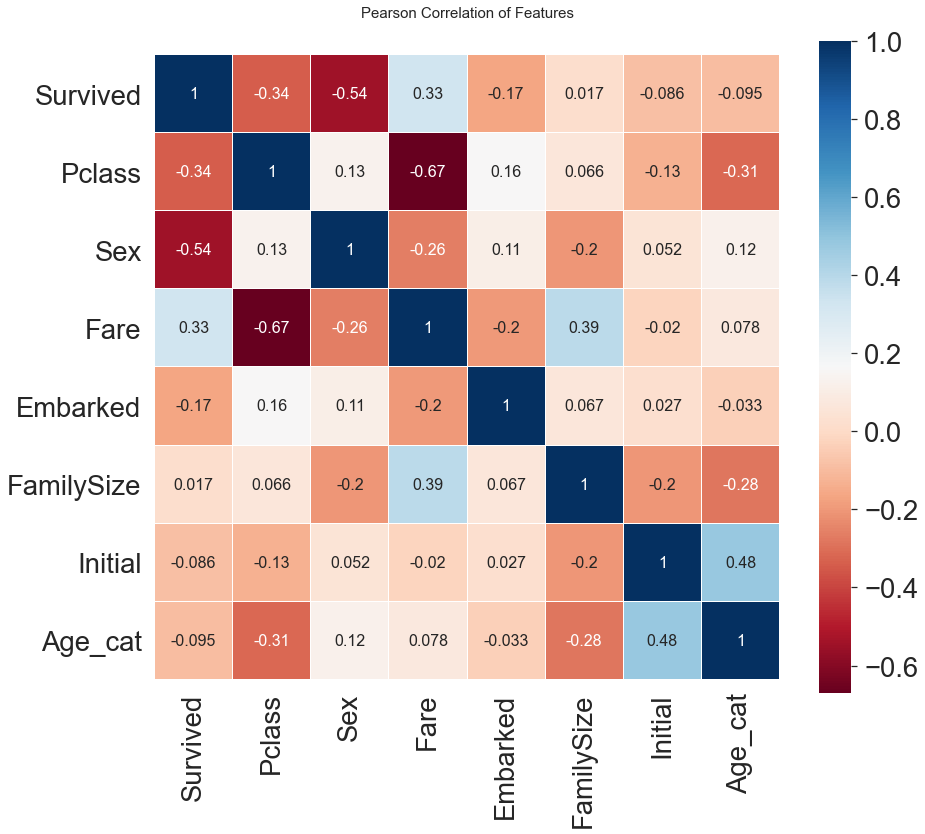

In [152]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={'Size': 16})

del heatmap_data

EDA에서 살펴봤듯이, Sex와 Pclass가 Survived에 상관관계가 어느정도 있음을 볼 수 있습니다.

생각보다 Fare와 Embarked도 상관관계가 있음을 볼 수 있습니다.

또한 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 가지는 피처들이 없다는 것입니다.

이것은 우리가 모델을 학습시킬 때 불필요한(redundant, superfluous) 피처가 없다는 것을 의미합니다. 1 또는 -1의 상관관계를 가진 피처 A, B가 있다면 우리가 얻을 수 있는 정보는 사실 하나이기 때문입니다.

이제 모델 학습에 앞서 전처리를 진행하겠습니다.

## 3.4 One-hot encoding on Initial and Embarked

수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 원핫 인코딩을 해줄 수 있습니다.

수치화는 간단히 Master=0, Miss=1, Mr=2, ... 로 매핑하는 것을 말합니다.

원핫 인코딩은 위 카테고리를 0과 1로 이루어진 다차원의 벡터로 나타내는 것을 말합니다.

pandas의 get_dummies를 사용하여 해결할 수 있습니다.

Initial을 prefix로 두어서 구분이 쉽게 만들어 줍니다.

In [153]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [154]:
df_train

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",1,0,0,211536,2.564949,NaN,2,1,2,0,0,0,0,1
887,888,1,1,"Graham, Miss. Margaret Edith",0,0,0,112053,3.401197,B42,2,1,1,0,1,0,0,0
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",0,1,2,W./C. 6607,3.154870,NaN,2,4,2,0,1,0,0,0
889,890,1,1,"Behr, Mr. Karl Howell",1,0,0,111369,3.401197,C148,0,1,2,0,0,1,0,0


Embarked에도 적용하겠습니다. initial과 마찬가지로 원핫인코딩을 사용해 표현하겠습니다.

In [155]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

## 3.5 Drop columns

이제 필요한 칼럼만 남기고 다 지웁니다.

In [156]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [157]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


# 4. Building machine learning model and prediction using the trained model

이제 sklearn을 사용해 본격적으로 머신러닝 모델을 만들어 봅시다.

In [158]:
#importing all the required ML packages
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

타이타닉 문제는 target class(survived)가 있으며, target class는 0, 1로 이루어져 있으므로(binary) binary classification 문제입니다.

우리가 지금 가지고 있는 train set의 survived를 제외한 input을 가지고 모델을 최적화시켜서 각 샘플의 생존유무를 판단하는 모델을 만들어 냅니다.

그 후 모델이 학습하지 않았던 test set을 input으로 주어서 test set의 각 샘플의 생존 유무를 예측해봅니다.

## 4.1 Preparation - Split dataset into train, valid, test set

가장 먼저 학습에 쓰일 데이터와 target label(Survived)을 분리합니다.

In [159]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

보통 train, test만 언급되지만, 실제 좋은 모델을 만들기 위해서 우리는 valid set을 따로 만들어 모델 평가를 해봅니다.

마치 축구대표팀이 팀훈련(train)을 하고 바로 월드컵(test)에 나가는 것이 아닌, train을 한 다음 평가전(valid)을 거쳐 훈련정도를 확인하고 월드컵에 나가는 것과 비슷합니다.

train_test_split을 사용하여 쉽게 train 셋을 분리할 수 있습니다.

In [160]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

본 튜토리얼에서는 랜덤포레스트 모델을 사용하도록 하겠습니다.

랜덤포레스트는 결정트리기반 모델이며, 여러 결정 트리들을 앙상블한 모델입니다.

각 머신러닝 알고리즘에는 여러 파라미터들이 있습니다. 랜덤포레스트분류기도 n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf 등 여러 파라미터들이 존재합니다. 이것들이 어떻게 세팅되냐에 따라 같은 데이터셋이라 하더라도 모델의 성능이 달라집니다.

파라미터 튜닝은 시간, 경험, 알고리즘에 대한 이해등이 필요합니다.

## 4.2 Model generation and prediction

In [161]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

단 세줄만으로 모델을 세우고 예측까지 해봤습니다.

이제 성능을 살펴보겠습니다.

In [162]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100*metrics.accuracy_score(prediction, y_vld)))

총 268명 중 82.84% 정확도로 생존을 맞춤


## 4.3 Feature importance

학습된 모델은 feature importance를 가지게 되는데, 우리는 이것을 확인하여 지금 만든 모델이 어떤 피처에 영향을 많이 받았는지 확인할 수 있습니다.

쉽게 말해 10 = 4x1 + 2x2 + 1x3을 생각하면 우리는 x1이 결과값(10)에 큰 영향을 준다고 생각할 수 있습니다. feature importance는 4, 2, 1을 이야기하며 x1이 가장 큰 값(4)를 가지므로, 이 모델에 가장 큰 영향을 미친다고 말할 수 있습니다.

학습된 모델은 기본적으로 feature importance를 가지고 있어서 쉽게 그 수치를 얻을 수 있습니다.

In [163]:
from pandas import Series

In [164]:
feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

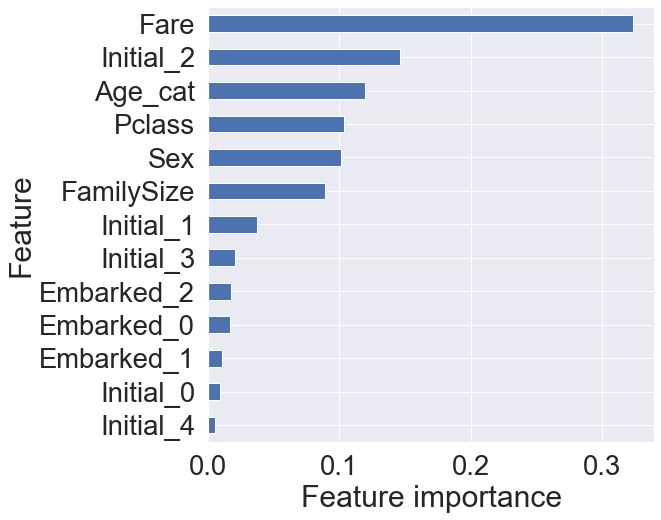

In [165]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')
plt.show()

우리가 얻은 모델에서는 Fare가 가장 큰 영향력을 가지며, 그 뒤로 Initial_2, Age_cat, Pclass가 차례로 중요도를 가집니다.

사실 feature importance는 지금 모델에서의 importance를 나타냅니다. 만약 다른 모델을 사용하게 된다면 feature importance가 다르게 나올 수 있습니다.

이 feature importance를 보고 실제로 Fare가 중요한 피처라고 판단을 내릴 수 있지만, 이것은 모델에 귀속되는 결론이므로 통계적으로 더 살펴봐야합니다.

feature importance를 가지고 좀 더 정확도가 높은 모델을 얻기 위해 피처 셀렉션을 할 수도 있고, 좀 더 빠른 모델을 위해 피처를 제거할 수도 있습니다.



## 4.2 Prediction on Test set

이제 모델이 학습하지 않았던 테스트셋을 모델에 주어서 생존여부를 예측해보겠습니다.

이 결과는 실제로 제출용이므로 결과는 리더보드에서 확인할 수 있습니다.

캐글에서 준 파일, gender_submission.csv 파일을 읽어서 제출 준비를 하겠습니다.

In [166]:
submission = pd.read_csv('./gender_submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


이제 testset에 대하여 예측을 하고, 결과를 csv 파일로 저장해보겠습니다.

In [167]:
prediction = model.predict(X_test)
submission['Survived'] = prediction

In [170]:
submission.to_csv('./my_first_submission.csv', index=False)

# 2회차 

In [1]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=2.5)
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [2]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')

In [3]:
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

In [4]:
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

In [5]:
df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

# 3. Feature engineering

본격적인 feature engineering 을 시작해보겠습니다.

가장 먼저, dataset 에 존재하는 null data를 채우려고 합니다.

아무 숫자로 채울 수는 없고, null data 를 포함하는 feature 의 statistics 를 참고하거나, 다른 아이디어를 짜내어 채울 수 있습니다.

null data 를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있기 때문에, 신경써줘야할 부분입니다.

Feature engineering 은 실제 모델의 학습에 쓰려고 하는 것이므로, train 뿐만아닐라 test 도 똑같이 적용해주어야 합니다. 잊지맙시다.

## 3.1 Fill Null

### 3.1.1 Fill Null in Age using title

Age 에는 null data가 177개나 있습니다. 이를 채울 수 있는 여러 아이디어가 있을 것인데, 여기서 우리는 title + statistics 를 사용해 보겠습니다.

영어에서는 Miss, Mrr, Mrs 같은 title이 존재합니다. 각 탑승객의 이름에는 꼭 이런 title 이 들어가게 되는데 이를 사용해보겠습니다.

pandas series 에는 data 를 string 으로 바꿔주는 str method, 거기에 정규표현식을 적용하게 해주는 extract method가 있습니다. 이를 사용하여 title 을 쉽게 추출할 수 있습니다. title을 Initial column에 저장하겠습니다

In [6]:
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')

pandas 의 crosstab 을 이용하여 우리가 추출한 Initial 과 Sex 간의 count 를 살펴봅시다.

In [7]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


위 table 을 참고하여, 남자, 여자가 쓰는 initial 을 구분해 보겠습니다. replace 메소드를 사용하면, 특정 데이터 값을 원하는 값으로 치환해줍니다.

In [8]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'], ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'], inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [9]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


여성과 관계있는 Miss, Mr, Mrs 가 생존률이 높은 것을 볼 수 있습니다.

<AxesSubplot:xlabel='Initial'>

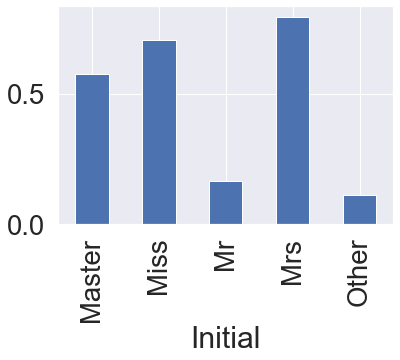

In [11]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

이제 본격적으로 Null 을 채울 것입니다. null data 를 채우는 방법은 정말 많이 존재합니다. statistics 를 활용하는 방법도 있고, null data 가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있습니다. 여기서는 statistics 를 활용하는 방법을 사용할 것입니다.

여기서 statistics 는 train data 의 것을 의미합니다. 우리는 언제나 test 를 unseen 으로 둔 상태로 놔둬야 하며, train 에서 얻은 statistics 를 기반으로 test 의 null data 를 채워줘야 합니다.

In [12]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


Age의 평균을 이용해 Null value 를 채우도록 하겠습니다.

pandas dataframe 을 다룰 때에는 boolean array를 이용해 indexing 하는 방법이 참으로 편리합니다.

아래 코드 첫줄을 해석하자면, isnull() 이면서 Initial 이 Mr 인 조건을 만족하는 row(탑승객) 의 'Age' 의 값을 33으로 치환한다 입니다.

loc + boolean + column 을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해집시다.

In [13]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'), 'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'), 'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'), 'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'), 'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'), 'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'), 'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'), 'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'), 'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'), 'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'), 'Age'] = 46

### 3.1.2 Fill Null in Embarked

In [14]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), 'Null values')

Embarked has  2 Null values


Embarked 는 Null value 가 2개이고, S 에서 가장 많은 탑승객이 있었으므로, 간단하게 Null 을 S로 채우겠습니다.

dataframe 의 fillna method 를 이용하면 쉽게 채울 수 있습니다. 여기서 inplace=True 로 하면 df_train 에 fillna 를 실제로 적용하게 됩니다

In [15]:
df_train['Embarked'].fillna('S', inplace=True)

## 3.2 Change Age(continuous to categorical)

Age 는 현재 continuous feature 입니다. 이대로 써도 모델을 세울 수 있지만, Age 를 몇개의 group 으로 나누어 category 화 시켜줄 수 도 있습니다. continuous 를 categorical 로 바꾸면 자칫 information loss 가 생길 수도 있습니다만, 본 튜토리얼에서는 다양한 방법을 소개하는 것이 목적이므로 진행하도록 하겠습니다.

방법은 여러가지가 있습니다. dataframe 의 indexing 방법인 loc 를 사용하여 직접해줄 수 있고, 아니면 apply 를 사용해 함수를 넣어줄 수 있습니다.

첫번째로 loc 를 사용한 방법입니다. loc 는 자주쓰게 되므로 그 사용법을 숙지하시면 좋습니다.
나이는 10살 간격으로 나누겠습니다.

In [16]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[70 <= df_train['Age'], 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

두번째로 간단한 함수를 만들어 apply 메소드에 넣어주는 방법입니다.

In [17]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7

In [18]:
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

두가지 방법이 잘 적용됬다면, 둘다 같은 결과를 내야합니다.

이를 확인하기 위해 Series 간 boolean 비교 후 all() 메소드를 사용합시다. all() 메소드는 모든 값이 True 면 True, 하나라도 False 가 있으면 False 를 줍니다.

In [19]:
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True -> ', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True ->  True


보시다시피 True 입니다. 둘 중 편한 걸 선택하시면 됩니다.

이제 중복되는 Age_cat 컬럼과 원래 컬럼 Age 를 제거하겠습니다.

In [20]:
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

## 3.3 Change Initial, Embarked and Sex (string to numerical)

현재 Initial 은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있습니다. 이런 카테고리로 표현되어져 있는 데이터를 모델에 인풋으로 넣어줄 때 우리가 해야할 것은 먼저 컴퓨터가 인식할 수 있도록 수치화 시켜야 합니다.

map method 를 가지고 간단히 할 수 있습니다.

사전 순서대로 정리하여 mapping 하겠습니다

In [21]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

Embarked 도 C, Q, S로 이루어져 있습니다. map 을 이용해 바꿔봅시다.

그러기 앞서서, 특정 column 에 어떤 값들이 있는 지 확인해보는 방법을 잠깐 살펴보겠습니다. 간단히 unique() 메소드를 쓰거나, value_counts() 를 써서 count 까지 보는 방법이 있습니다.

In [22]:
df_train["Embarked"].unique()

array(['S', 'C', 'Q'], dtype=object)

In [23]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

위 두 방법을 사용해 Embarked가 S, C, Q 세가지로 이루어진 것을 볼 수 있습니다. 이제 map을 사용해봅시다

In [24]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

한번 Null 이 사라졌는지 확인해봅시다. Embarked Column만 가져온 것은 하나의 pandas의 Series 객체므로, isnull() 메소드를 사용해 Series의 값들이 null 인지 아닌지에 대한 boolean 값을 얻을 수 있습니다. 그리고 이것에 any() 를 사용하여, True 가 단하나라도 있을 시(Null이 한개라도 있을 시) True 를 반환해주게 됩니다. 우리는 Null 을 S로 다 바꿔주었으므로 False 를 얻게 됩니다

In [25]:
df_train['Embarked'].isnull().any()

False

Sex 도 Female, male 로 이루어져 있습니다. map 을 이용해 바꿔봅시다.

In [26]:
df_train['Sex'] = df_train["Sex"].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test["Sex"].map({'female': 0, 'male': 1})

이제 각 feature 간의 상관관계를 한번 보려고 합니다. 두 변수간의 Pearson correlation 을 구하면 (-1, 1) 사이의 값을 얻을 수 있습니다. -1로 갈수록 음의 상관관계, 1로 갈수록 양의 상관관계를 의미하며, 0은 상관관계가 없다는 것을 의미합니다. 구하는 수식은 아래와 같습니다.

$r_{xy} = \frac{Cov(x,y)}{S_{x}S_{y}} = \frac{\frac{1}{n-1}\sum_{i=1}^n(x_{i}-\bar x)(y_{i}-\bar y)}{S_{x}S_{y}}$

우리는 여러 feature 를 가지고 있으니 이를 하나의 maxtrix 형태로 보면 편할 텐데, 이를 heatmap plot 이라고 하며, dataframe 의 corr() 메소드와 seaborn 을 가지고 편하게 그릴 수 있습니다.

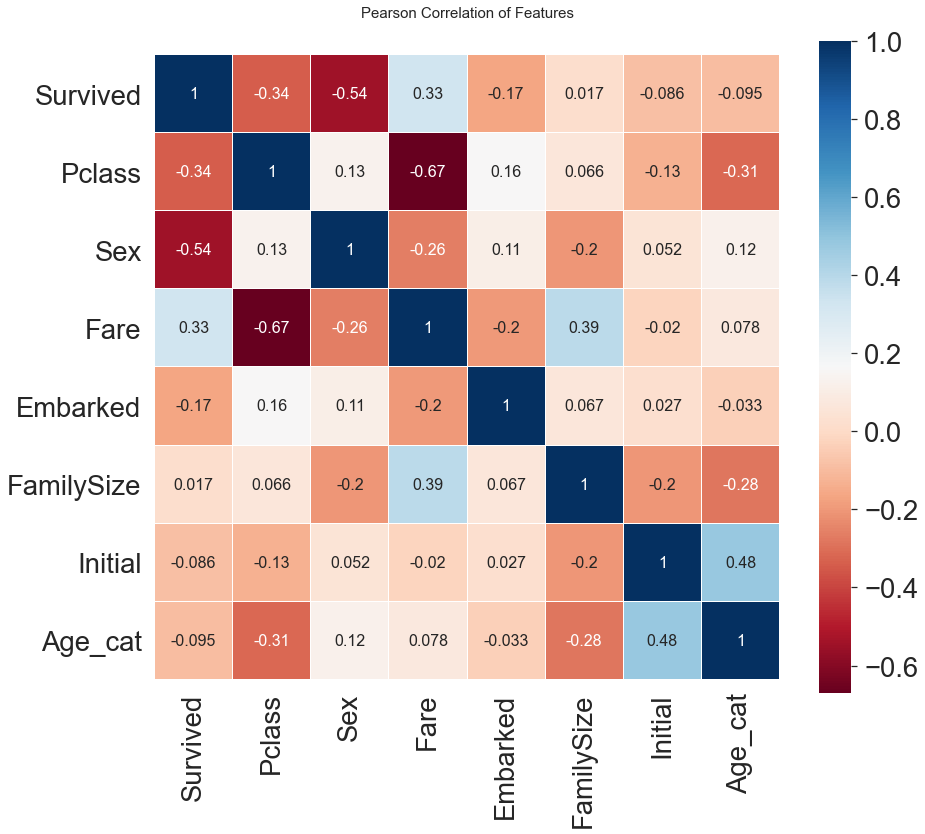

In [81]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1.0, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={'size': 16})
del heatmap_data

우리가 EDA에서 살펴봤듯이, Sex 와 Pclass 가 Survived 에 상관관계가 어느 정도 있음을 볼 수 있습니다.

생각보다 fare 와 Embarked 도 상관관계가 있음을 볼 수 있습니다.

또한 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 가지는 feature들이 없다는 것입니다.

이것은 우리가 모델을 학습시킬 때, 불필요한(redundant, superfluous) feature 가 없다는 것을 의미합니다. 1 또는 -1 의 상관관계를 가진 feature A, B 가 있다면, 우리가 얻을 수 있는 정보는 사실 하나일 거니까요.

이제 실제로 모델을 학습시키기 앞서서 data preprocessing (전처리)을 진행해보겠습니다.

## 3.4 One-hot encoding on Initial and Embarked

수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해줄 수 있습니다.

수치화는 간단히 Master == 0, Miss == 1, Mr == 2, Mrs == 3, Other == 4 로 매핑해주는 것을 말합니다.

pandas 의 get_dummies 를 사용하여 쉽게 해결 할 수 있습니다.

총 5개의 카테고리니, one-hot encoding 을 하고 나면 새로운 5개의 column 이 생겨납니다.

Initial 을 prefix로 두어서 구분이 쉽게 만들어 줍니다.

In [29]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix="Initial")
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix="Initial")

In [30]:
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,1,0,3,"Braund, Mr. Owen Harris",1,1,0,A/5 21171,1.981001,NaN,2,2,2,0,0,1,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,0,PC 17599,4.266662,C85,0,2,3,0,0,0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",0,0,0,STON/O2. 3101282,2.070022,NaN,2,1,2,0,1,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,0,113803,3.972177,C123,2,2,3,0,0,0,1,0
4,5,0,3,"Allen, Mr. William Henry",1,0,0,373450,2.085672,NaN,2,1,3,0,0,1,0,0


In [31]:
df_test.head()

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,892,3,"Kelly, Mr. James",1,0,0,330911,2.057860,NaN,1,1,3,0,0,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,1,0,363272,1.945910,NaN,2,2,4,0,0,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",1,0,0,240276,2.270836,NaN,1,1,6,0,0,1,0,0
3,895,3,"Wirz, Mr. Albert",1,0,0,315154,2.159003,NaN,2,1,2,0,0,1,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1,1,3101298,2.508582,NaN,2,3,2,0,0,0,1,0


보시다시피 오른쪽에 우리가 만들려고 했던 one-hot encoded columns 가 생성된 것이 보입니다.

Embarked 에도 적용하겠습니다. Initial 때와 마찬가지로 one-hot encoding 을 사용해 표현하겠습니다.

In [32]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test= pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

아주 쉽게 one-hot encoding 을 적용했습니다.

sklearn 로 Labelencoder + OneHotencoder 이용해도 one-hot encoding 이 가능합니다.

가끔 category 가 100개가 넘어가는 경우가 있습니다. 이때 one-hot encoding을 사용하면 column이 100개가 생겨, 학습시 매우 버거울 경우가 있습니다. 이런 경우는 다른 방법을 사용하기도 하는데, 이는 다음에 한번 다뤄보겠습니다.

## 3.5 Drop columns

필요한 칼럼만 남기고 다 지웁니다.

In [33]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [34]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


보시다시피, train 의 Survived feature(target class)를 빼면 train, test 둘다 같은 columns 를 가진 걸 확인할 수 있습니다.

# 4. Building machine learning model and prediction using the trained model

In [35]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

Sklearn 은 머신러닝의 처음부터 끝까지가 다 있습니다. feature engineering, preprocessing, 지도 학습 알고리즘, 비지도 학습 알고리즘, 모델 평가, 파이프라인 등 머신러닝에 관련된 모든 작업들이 손쉬운 인터페이스로 구현되어 있습니다. 데이터 분석 + 머신러닝을 하고싶다면, 이 라이브러리는 반드시 숙지해야합니다.

지금 타이타닉 문제는 target class(survived)가 있으며, target class 는 0, 1로 이루어져 있으므로(binary) binary classfication 문제입니다.

우리가 지금 가지고 있는 train set 의 survived를 제외한 input 을 가지고 모델을 최적화시켜서 각 샘플(탑승객)의 생존유무를 판단하는 모델을 만들어 냅니다.

그 후 모델이 학습하지 않았던 test set 을 input 으로 주어서 test set 의 각 샘플(탑승객)의 생존 유무를 예측해봅니다.

## 4.1 Preparation - Split dataset into train, valid, test set

가장 먼저, 학습에 쓰일 데이터와, target label(Survived)를 분리합니다. drop 을 사용해 간단히 할 수 있습니다.

In [36]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

보통 train, test 만 언급되지만, 실제 좋은 모델을 만들기 위해서 우리는 valid set을 따로 만들어 모델 평가를 해봅니다.

마치 축구대표팀이 팀훈련(train)을 하고 바로 월드컵(test)로 나가는 것이 아니라, 팀훈련(train)을 한 다음 평가전(valid)를 거쳐 팀의 훈련 정도(학습정도)를 확인하고 월드컵(test)에 나가는 것과 비슷합니다.

train_test_split 을 사용하여 쉽게 train 셋을 분리할 수 있습니다.

In [37]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)

본 튜토리얼에서는 랜덤포레스트 모델을 사용하도록 하겠습니다.

랜덤포레스트는 결정트리기반 모델이며, 여러 결정 트리들을 앙상블한 모델입니다. 

각 머신러닝 알고리즘에는 여러 파라미터들이 있습니다. 랜덤포레스트분류기도 n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf 등 여러 파라미터들이 존재합니다. 이것들이 어떻게 세팅되냐에 따라 같은 데이터셋이라 하더라도 모델의 성능이 달라집니다.

일단 지금은 튜토리얼이니 파라미터 튜닝은 잠시 제쳐두기로 하고, 기본 default 세팅으로 진행하겠습니다.

모델 객체를 만들고, fit 메소드로 학습시킵니다.
그런 후 valid set input 을 넣어주어 예측값(X_vld sample(탑승객)의 생존여부)를 얻습니다.

## Model generation and prediction

In [39]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

단 세줄만으로 여러분은 모델을 세우고, 예측까지 해봤습니다.

자, 이제 모델의 성능을 한번 살펴보겠습니다.

In [40]:
print('총 {}명 중 {:.2f}% 정확도로 생존을 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 82.09% 정확도로 생존을 맞춤


## 4.3 Feature importance

학습된 모델은 feature importance 를 가지게 되는데, 우리는 이것을 확인하여 지금 만든 모델이 어떤 feature 에 영향을 많이 받았는 지 확인할 수 있습니다.

쉽게 말해, 10 = 4x1 + 2x2 + 1*x3 을 생각하면, 우리는 x1이 결과값(10)에 큰 영향을 준다고 생각 할 수 있습니다. feature importance 는 4, 2, 1 을 이야기하며, x1이 가장 큰 값(4)를 가지므로, 이 모델에 가장 큰 영향을 미친다고 말할 수 있습니다.

학습된 모델은 기본적으로 featureimportances 를 가지고 있어서 쉽게 그 수치를 얻을 수 있습니다.

pandas series 를 이용하면 쉽게 sorting 을 하여 그래프를 그릴 수 있습니다.

In [41]:
from pandas import Series

In [42]:
feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

Text(0, 0.5, 'Feature')

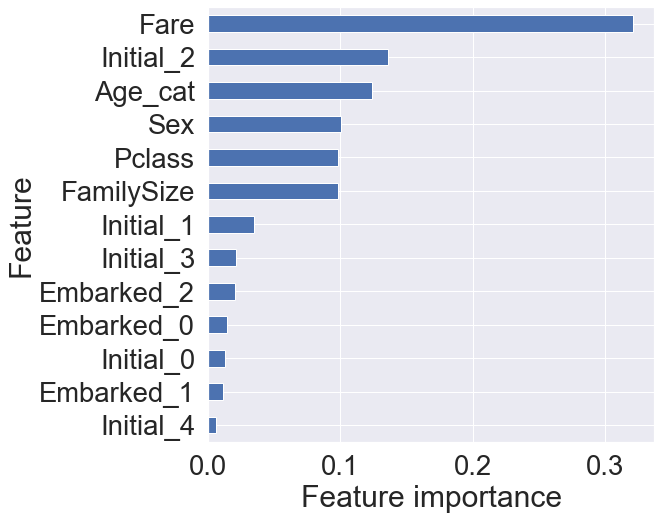

In [43]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')

우리가 얻은 모델에서는 Fare 가 가장 큰 영향력을 가지며, 그 뒤로 Initial_2, Age_cat, Pclass가 차례로 중요도를 가집니다

사실 feature importance 는 지금 모델에서의 importance 를 나타냅니다. 만약 다른 모델을 사용하게 된다면 feature importance 가 다르게 나올 수 있습니다.

이 feature importance 를 보고 실제로 Fare 가 중요한 feature 일 수 있다고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 좀 더 살펴보긴 해야합니다.

featuure importance 를 가지고 좀 더 정확도가 높은 모델을 얻기 위해 feature selection 을 할 수도 있고, 좀 더 빠른 모델을 위해 feature 제거를 할 수 있습니다.

## 4.4 Prediction on Test set

이제 모델이 학습하지 않았던(보지 않았던) 테스트셋을 모델에 주어서, 생존여부를 예측해보겠습니다.

이 결과는 실제로 submission(제출용) 이므로 결과는 leaderboard 에서 확인할 수 있습니다.

캐글에서 준 파일, gender_submission.csv 파일을 읽어서 제출 준비를 하겠습니다.

In [44]:
submission = pd.read_csv('./gender_submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


이제 testset 에 대하여 예측을 하고, 결과를 csv 파일로 저장해보겠습니다.

In [45]:
prediction = model.predict(X_test)
submission['Survived'] = prediction
submission.to_csv('./my_first_submission.csv', index=False)

# 3회차

In [46]:
import numpy as np
import pandas as pd
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')
sns.set(font_scale=2.5)
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

In [93]:
df_train = pd.read_csv('./train.csv')
df_test = pd.read_csv('./test.csv')
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1

In [94]:
df_test.loc[df_test.Fare.isnull(), 'Fare'] = df_test['Fare'].mean()

In [95]:
df_train['Fare'] = df_train['Fare'].map(lambda i: np.log(i) if i > 0 else 0)
df_test['Fare'] = df_test['Fare'].map(lambda i: np.log(i) if i > 0 else 0)

## 3. Feature engineering

본격적인 feature engineering 을 시작해보겠습니다.

가장 먼저, dataset 에 존재하는 null data를 채우려고 합니다.

아무 숫자로 채울 수는 없고, null data 를 포함하는 feature 의 statistics 를 참고하거나, 다른 아이디어를 짜내어 채울 수 있습니다.

null data 를 어떻게 채우느냐에 따라 모델의 성능이 좌지우지될 수 있기 때문에, 신경써줘야할 부분입니다.

Feature engineering 은 실제 모델의 학습에 쓰려고 하는 것이므로, train 뿐만아닐라 test 도 똑같이 적용해주어야 합니다. 잊지맙시다.

## 3.1 Fill Null

### 3.1.1 Fill Null in Age using title

Age 에는 null data가 177개나 있습니다. 이를 채울 수 있는 여러 아이디어가 있을 것인데, 여기서 우리는 title + statistics 를 사용해 보겠습니다.

영어에서는 Miss, Mrr, Mrs 같은 title이 존재합니다. 각 탑승객의 이름에는 꼭 이런 title 이 들어가게 되는데 이를 사용해보겠습니다.

pandas series 에는 data 를 string 으로 바꿔주는 str method, 거기에 정규표현식을 적용하게 해주는 extract method가 있습니다. 이를 사용하여 title 을 쉽게 추출할 수 있습니다. title을 Initial column에 저장하겠습니다.

In [96]:
df_train['Initial'] = df_train.Name.str.extract('([A-Za-z]+)\.')
df_test['Initial'] = df_test.Name.str.extract('([A-Za-z]+)\.')

pandas 의 crosstab 을 이용하여 우리가 추출한 Initial 과 Sex 간의 count 를 살펴봅시다.

In [97]:
pd.crosstab(df_train['Initial'], df_train['Sex']).T.style.background_gradient(cmap='summer_r')

Initial,Capt,Col,Countess,Don,Dr,Jonkheer,Lady,Major,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir
Sex,,,,,,,,,,,,,,,,,
female,0,0,1,0,1,0,1,0,0,182,2,1,0,125,1,0,0
male,1,2,0,1,6,1,0,2,40,0,0,0,517,0,0,6,1


위 table 을 참고하여, 남자, 여자가 쓰는 initial 을 구분해 보겠습니다. replace 메소드를 사용하면, 특정 데이터 값을 원하는 값으로 치환해줍니다.

In [98]:
df_train['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

df_test['Initial'].replace(['Mlle','Mme','Ms','Dr','Major','Lady','Countess','Jonkheer','Col','Rev','Capt','Sir','Don', 'Dona'],
                        ['Miss','Miss','Miss','Mr','Mr','Mrs','Mrs','Other','Other','Other','Mr','Mr','Mr', 'Mr'],inplace=True)

In [99]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


여성과 관계있는 Miss, Mr, Mrs 가 생존률이 높은 것을 볼 수 있습니다.

<AxesSubplot:xlabel='Initial'>

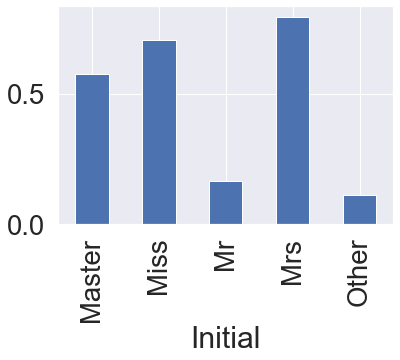

In [100]:
df_train.groupby('Initial')['Survived'].mean().plot.bar()

이제 본격적으로 Null 을 채울 것입니다. null data 를 채우는 방법은 정말 많이 존재합니다. statistics 를 활용하는 방법도 있고, null data 가 없는 데이터를 기반으로 새로운 머신러닝 알고리즘을 만들어 예측해서 채워넣는 방식도 있습니다. 여기서는 statistics 를 활용하는 방법을 사용할 것입니다.

여기서 statistics 는 train data 의 것을 의미합니다. 우리는 언제나 test 를 unseen 으로 둔 상태로 놔둬야 하며, train 에서 얻은 statistics 를 기반으로 test 의 null data 를 채워줘야 합니다.

In [101]:
df_train.groupby('Initial').mean()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,FamilySize
Initial,,,,,,,,
Master,414.975000,0.575000,2.625000,4.574167,2.300000,1.375000,3.340710,4.675000
Miss,411.741935,0.704301,2.284946,21.860000,0.698925,0.537634,3.123713,2.236559
Mr,455.880907,0.162571,2.381853,32.739609,0.293006,0.151229,2.651507,1.444234
Mrs,456.393701,0.795276,1.984252,35.981818,0.692913,0.818898,3.443751,2.511811
Other,564.444444,0.111111,1.666667,45.888889,0.111111,0.111111,2.641605,1.222222


Age의 평균을 이용해 Null value 를 채우도록 하겠습니다.

pandas dataframe 을 다룰 때에는 boolean array를 이용해 indexing 하는 방법이 참으로 편리합니다.

아래 코드 첫줄을 해석하자면, isnull() 이면서 Initial 이 Mr 인 조건을 만족하는 row(탑승객) 의 'Age' 의 값을 33으로 치환한다 입니다.

loc + boolean + column 을 사용해 값을 치환하는 방법은 자주 쓰이므로 꼭 익숙해집시다.

In [102]:
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mr'),'Age'] = 33
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Mrs'),'Age'] = 36
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Master'),'Age'] = 5
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Miss'),'Age'] = 22
df_train.loc[(df_train.Age.isnull())&(df_train.Initial=='Other'),'Age'] = 46

df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mr'),'Age'] = 33
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Mrs'),'Age'] = 36
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Master'),'Age'] = 5
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Miss'),'Age'] = 22
df_test.loc[(df_test.Age.isnull())&(df_test.Initial=='Other'),'Age'] = 46

### 3.1.2 Fill Null in Embarked

In [103]:
print('Embarked has ', sum(df_train['Embarked'].isnull()), 'Null values')

Embarked has  2 Null values


Embarked 는 Null value 가 2개이고, S 에서 가장 많은 탑승객이 있었으므로, 간단하게 Null 을 S로 채우겠습니다.

dataframe 의 fillna method 를 이용하면 쉽게 채울 수 있습니다. 여기서 inplace=True 로 하면 df_train 에 fillna 를 실제로 적용하게 됩니다

In [104]:
df_train['Embarked'].fillna('S', inplace=True)

## 3.2 Change Age(continuous to categorical)

Age 는 현재 continuous feature 입니다. 이대로 써도 모델을 세울 수 있지만, Age 를 몇개의 group 으로 나누어 category 화 시켜줄 수 도 있습니다. continuous 를 categorical 로 바꾸면 자칫 information loss 가 생길 수도 있습니다만, 본 튜토리얼에서는 다양한 방법을 소개하는 것이 목적이므로 진행하도록 하겠습니다.

방법은 여러가지가 있습니다. dataframe 의 indexing 방법인 loc 를 사용하여 직접해줄 수 있고, 아니면 apply 를 사용해 함수를 넣어줄 수 있습니다.

첫번째로 loc 를 사용한 방법입니다. loc 는 자주쓰게 되므로 그 사용법을 숙지하시면 좋습니다.

나이는 10살 간격으로 나누겠습니다.

In [105]:
df_train['Age_cat'] = 0
df_train.loc[df_train['Age'] < 10, 'Age_cat'] = 0
df_train.loc[(10 <= df_train['Age']) & (df_train['Age'] < 20), 'Age_cat'] = 1
df_train.loc[(20 <= df_train['Age']) & (df_train['Age'] < 30), 'Age_cat'] = 2
df_train.loc[(30 <= df_train['Age']) & (df_train['Age'] < 40), 'Age_cat'] = 3
df_train.loc[(40 <= df_train['Age']) & (df_train['Age'] < 50), 'Age_cat'] = 4
df_train.loc[(50 <= df_train['Age']) & (df_train['Age'] < 60), 'Age_cat'] = 5
df_train.loc[(60 <= df_train['Age']) & (df_train['Age'] < 70), 'Age_cat'] = 6
df_train.loc[df_train['Age'] >= 70, 'Age_cat'] = 7

df_test['Age_cat'] = 0
df_test.loc[df_test['Age'] < 10, 'Age_cat'] = 0
df_test.loc[(10 <= df_test['Age']) & (df_test['Age'] < 20), 'Age_cat'] = 1
df_test.loc[(20 <= df_test['Age']) & (df_test['Age'] < 30), 'Age_cat'] = 2
df_test.loc[(30 <= df_test['Age']) & (df_test['Age'] < 40), 'Age_cat'] = 3
df_test.loc[(40 <= df_test['Age']) & (df_test['Age'] < 50), 'Age_cat'] = 4
df_test.loc[(50 <= df_test['Age']) & (df_test['Age'] < 60), 'Age_cat'] = 5
df_test.loc[(60 <= df_test['Age']) & (df_test['Age'] < 70), 'Age_cat'] = 6
df_test.loc[70 <= df_test['Age'], 'Age_cat'] = 7

두번째로 간단한 함수를 만들어 apply 메소드에 넣어주는 방법입니다.

In [106]:
def category_age(x):
    if x < 10:
        return 0
    elif x < 20:
        return 1
    elif x < 30:
        return 2
    elif x < 40:
        return 3
    elif x < 50:
        return 4
    elif x < 60:
        return 5
    elif x < 70:
        return 6
    else:
        return 7

In [107]:
df_train['Age_cat_2'] = df_train['Age'].apply(category_age)

두가지 방법이 잘 적용됬다면, 둘다 같은 결과를 내야합니다.

이를 확인하기 위해 Series 간 boolean 비교 후 all() 메소드를 사용합시다. all() 메소드는 모든 값이 True 면 True, 하나라도 False 가 있으면 False 를 줍니다.

In [108]:
print('1번 방법, 2번 방법 둘다 같은 결과를 내면 True -> ', (df_train['Age_cat'] == df_train['Age_cat_2']).all())

1번 방법, 2번 방법 둘다 같은 결과를 내면 True ->  True


보시다시피 True 입니다. 둘 중 편한 걸 선택하시면 됩니다.

이제 중복되는 Age_cat 컬럼과 원래 컬럼 Age 를 제거하겠습니다.

In [109]:
df_train.drop(['Age', 'Age_cat_2'], axis=1, inplace=True)
df_test.drop(['Age'], axis=1, inplace=True)

## 3.3 Change Initial, Embarked and Sex (string to numerical)

현재 Initial 은 Mr, Mrs, Miss, Master, Other 총 5개로 이루어져 있습니다. 이런 카테고리로 표현되어져 있는 데이터를 모델에 인풋으로 넣어줄 때 우리가 해야할 것은 먼저 컴퓨터가 인식할 수 있도록 수치화 시켜야 합니다.

map method 를 가지고 간단히 할 수 있습니다.

사전 순서대로 정리하여 mapping 하겠습니다

In [110]:
df_train['Initial'] = df_train['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})
df_test['Initial'] = df_test['Initial'].map({'Master': 0, 'Miss': 1, 'Mr': 2, 'Mrs': 3, 'Other': 4})

Embarked 도 C, Q, S로 이루어져 있습니다. map 을 이용해 바꿔봅시다.

그러기 앞서서, 특정 column 에 어떤 값들이 있는 지 확인해보는 방법을 잠깐 살펴보겠습니다. 간단히 unique() 메소드를 쓰거나, value_counts() 를 써서 count 까지 보는 방법이 있습니다.

In [111]:
df_train['Embarked'].unique()

array(['S', 'C', 'Q'], dtype=object)

In [112]:
df_train['Embarked'].value_counts()

S    646
C    168
Q     77
Name: Embarked, dtype: int64

위 두 방법을 사용해 Embarked가 S, C, Q 세가지로 이루어진 것을 볼 수 있습니다. 이제 map을 사용해봅시다

In [113]:
df_train['Embarked'] = df_train['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})
df_test['Embarked'] = df_test['Embarked'].map({'C': 0, 'Q': 1, 'S': 2})

한번 Null 이 사라졌는지 확인해봅시다. Embarked Column만 가져온 것은 하나의 pandas의 Series 객체므로, isnull() 메소드를 사용해 Series의 값들이 null 인지 아닌지에 대한 boolean 값을 얻을 수 있습니다. 그리고 이것에 any() 를 사용하여, True 가 단하나라도 있을 시(Null이 한개라도 있을 시) True 를 반환해주게 됩니다. 우리는 Null 을 S로 다 바꿔주었으므로 False 를 얻게 됩니다

In [114]:
df_train['Embarked'].isnull().any()

False

Sex 도 Female, male 로 이루어져 있습니다. map 을 이용해 바꿔봅시다.

In [115]:
df_train['Sex'] = df_train['Sex'].map({'female': 0, 'male': 1})
df_test['Sex'] = df_test['Sex'].map({'female': 0, 'male': 1})

두 변수간의 Pearson correlation 을 구하면 (-1, 1) 사이의 값을 얻을 수 있습니다. -1로 갈수록 음의 상관관계, 1로 갈수록 양의 상관관계를 의미하며, 0은 상관관계가 없다는 것을 의미합니다. 구하는 수식은 아래와 같습니다.

$$r_{xy} = \frac{Cov(x,y)}{S_{x}S_{y}} = \frac{\frac{1}{n-1}\sum_{i=1}^n(x_{i}-\bar x)(y_{i}-\bar y)}{S_{x}S_{y}}$$

우리는 여러 feature 를 가지고 있으니 이를 하나의 maxtrix 형태로 보면 편할 텐데, 이를 heatmap plot 이라고 하며, dataframe 의 corr() 메소드와 seaborn 을 가지고 편하게 그릴 수 있습니다.

In [116]:
heatmap_data = df_train[['Survived', 'Pclass', 'Sex', 'Fare', 'Embarked', 'FamilySize', 'Initial', 'Age_cat']]

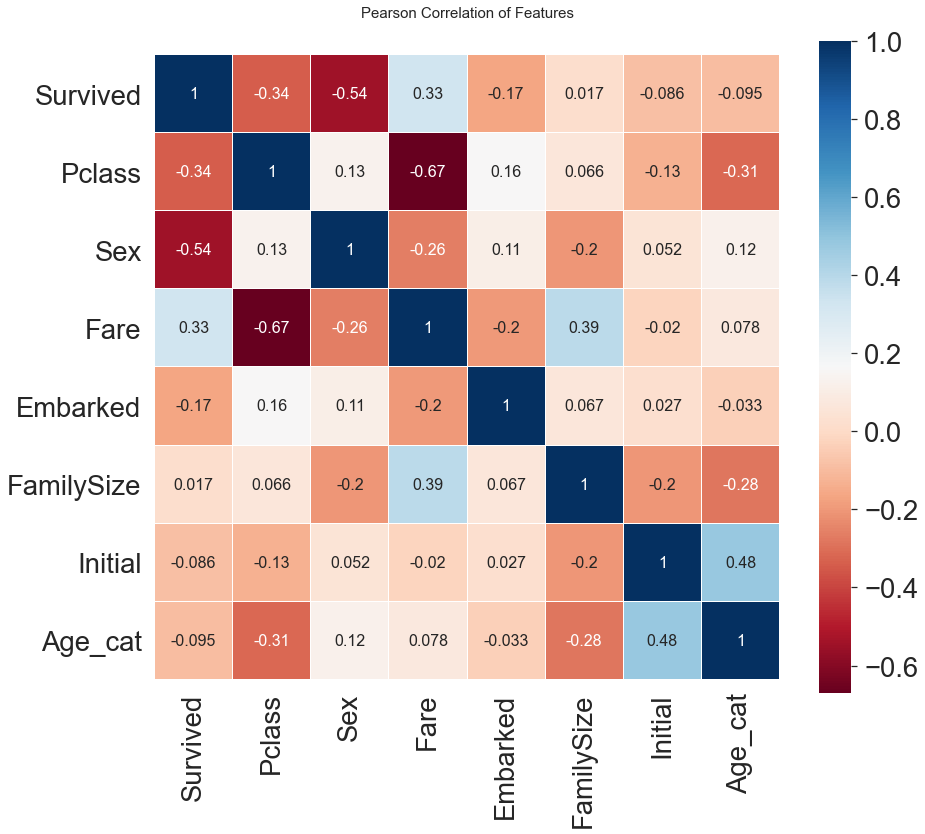

In [117]:
colormap = plt.cm.RdBu
plt.figure(figsize=(14, 12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(heatmap_data.astype(float).corr(), linewidths=0.1, vmax=1, square=True, cmap=colormap, linecolor='white', annot=True, annot_kws={'size': 16})
del heatmap_data

우리가 EDA에서 살펴봤듯이, Sex 와 Pclass 가 Survived 에 상관관계가 어느 정도 있음을 볼 수 있습니다.

생각보다 fare 와 Embarked 도 상관관계가 있음을 볼 수 있습니다.

또한 우리가 여기서 얻을 수 있는 정보는 서로 강한 상관관계를 가지는 feature들이 없다는 것입니다.

이것은 우리가 모델을 학습시킬 때, 불필요한(redundant, superfluous) feature 가 없다는 것을 의미합니다. 1 또는 -1 의 상관관계를 가진 feature A, B 가 있다면, 우리가 얻을 수 있는 정보는 사실 하나일 거니까요.

## 3.4 One-hot encoding on Initial and Embarked

수치화시킨 카테고리 데이터를 그대로 넣어도 되지만, 모델의 성능을 높이기 위해 one-hot encoding을 해줄 수 있습니다.

수치화는 간단히 Master == 0, Miss == 1, Mr == 2, Mrs == 3, Other == 4 로 매핑해주는 것을 말합니다.

One-hot encoding 은 위 카테고리를 아래와 같이 (0, 1) 로 이루어진 5차원의 벡터로 나타내는 것을 말합니다.

In [118]:
df_train = pd.get_dummies(df_train, columns=['Initial'], prefix='Initial')
df_test = pd.get_dummies(df_test, columns=['Initial'], prefix='Initial')

In [119]:
df_test.head()

,PassengerId,Pclass,Name,Sex,SibSp,Parch,Ticket,Fare,Cabin,Embarked,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4
0,892,3,"Kelly, Mr. James",1,0,0,330911,2.057860,NaN,1,1,3,0,0,1,0,0
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",0,1,0,363272,1.945910,NaN,2,2,4,0,0,0,1,0
2,894,2,"Myles, Mr. Thomas Francis",1,0,0,240276,2.270836,NaN,1,1,6,0,0,1,0,0
3,895,3,"Wirz, Mr. Albert",1,0,0,315154,2.159003,NaN,2,1,2,0,0,1,0,0
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",0,1,1,3101298,2.508582,NaN,2,3,2,0,0,0,1,0


보시다시피 오른쪽에 우리가 만들려고 했던 one-hot encoded columns 가 생성된 것이 보입니다

Embarked 에도 적용하겠습니다. Initial 때와 마찬가지로 one-hot encoding 을 사용해 표현하겠습니다.

In [120]:
df_train = pd.get_dummies(df_train, columns=['Embarked'], prefix='Embarked')
df_test = pd.get_dummies(df_test, columns=['Embarked'], prefix='Embarked')

아주 쉽게 one-hot encoding 을 적용했습니다.

sklearn 로 Labelencoder + OneHotencoder 이용해도 one-hot encoding 이 가능합니다.

다른 튜토리얼에서 한번 써보겠습니다. 여기서는 get_dummies 로 충분히 가능하기 때문에 get_dummies 만으로 끝내겠습니다.

가끔 category 가 100개가 넘어가는 경우가 있습니다. 이때 one-hot encoding을 사용하면 column이 100개가 생겨, 학습시 매우 버거울 경우가 있습니다. 이런 경우는 다른 방법을 사용하기도 하는데, 이는 다음에 한번 다뤄보겠습니다.

## 3.5 Drop columns

In [121]:
df_train.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)
df_test.drop(['PassengerId', 'Name', 'SibSp', 'Parch', 'Ticket', 'Cabin'], axis=1, inplace=True)

In [122]:
df_train.head()

,Survived,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,0,3,1,1.981001,2,2,0,0,1,0,0,0,0,1
1,1,1,0,4.266662,2,3,0,0,0,1,0,1,0,0
2,1,3,0,2.070022,1,2,0,1,0,0,0,0,0,1
3,1,1,0,3.972177,2,3,0,0,0,1,0,0,0,1
4,0,3,1,2.085672,1,3,0,0,1,0,0,0,0,1


In [123]:
df_test.head()

,Pclass,Sex,Fare,FamilySize,Age_cat,Initial_0,Initial_1,Initial_2,Initial_3,Initial_4,Embarked_0,Embarked_1,Embarked_2
0,3,1,2.057860,1,3,0,0,1,0,0,0,1,0
1,3,0,1.945910,2,4,0,0,0,1,0,0,0,1
2,2,1,2.270836,1,6,0,0,1,0,0,0,1,0
3,3,1,2.159003,1,2,0,0,1,0,0,0,0,1
4,3,0,2.508582,3,2,0,0,0,1,0,0,0,1


보시다시피, train 의 Survived feature(target class)를 빼면 train, test 둘다 같은 columns 를 가진 걸 확인할 수 있습니다.

# 4. Building machine learning model and prediction using the trained model

In [124]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.model_selection import train_test_split

Sklearn 은 머신러닝의 처음부터 끝까지가 다 있습니다. feature engineering, preprocessing, 지도 학습 알고리즘, 비지도 학습 알고리즘, 모델 평가, 파이프라인 등 머신러닝에 관련된 모든 작업들이 손쉬운 인터페이스로 구현되어 있습니다. 데이터 분석 + 머신러닝을 하고싶다면, 이 라이브러리는 반드시 숙지해야합니다.

파이썬 라이브러리를 활용한 머신러닝(Introduction to machine larning with Python)책을 사서 공부하시길 매우 추천해드립니다.

지금 타이타닉 문제는 target class(survived)가 있으며, target class 는 0, 1로 이루어져 있으므로(binary) binary classfication 문제입니다.

우리가 지금 가지고 있는 train set 의 survived를 제외한 input 을 가지고 모델을 최적화시켜서 각 샘플(탑승객)의 생존유무를 판단하는 모델을 만들어 냅니다.
그 후 모델이 학습하지 않았던 test set 을 input 으로 주어서 test set 의 각 샘플(탑승객)의 생존 유무를 예측해봅니다.

## 4.1 Preparation - Split dataset into train, valid, test set

가장 먼저, 학습에 쓰일 데이터와, target label(Survived)를 분리합니다. drop 을 사용해 간단히 할 수 있습니다.

In [125]:
X_train = df_train.drop('Survived', axis=1).values
target_label = df_train['Survived'].values
X_test = df_test.values

보통 train, test 만 언급되지만, 실제 좋은 모델을 만들기 위해서 우리는 valid set을 따로 만들어 모델 평가를 해봅니다.

마치 축구대표팀이 팀훈련(train)을 하고 바로 월드컵(test)로 나가는 것이 아니라, 팀훈련(train)을 한 다음 평가전(valid)를 거쳐 팀의 훈련 정도(학습정도)를 확인하고 월드컵(test)에 나가는 것과 비슷합니다.

train_test_split 을 사용하여 쉽게 train 셋을 분리할 수 있습니다.

In [126]:
X_tr, X_vld, y_tr, y_vld = train_test_split(X_train, target_label, test_size=0.3, random_state=2018)


본 튜토리얼에서는 랜덤포레스트 모델을 사용하도록 하겠습니다.

랜덤포레스트는 결정트리기반 모델이며, 여러 결정 트리들을 앙상블한 모델입니다. 

각 머신러닝 알고리즘에는 여러 파라미터들이 있습니다. 랜덤포레스트분류기도 n_estimators, max_features, max_depth, min_samples_split, min_samples_leaf 등 여러 파라미터들이 존재합니다. 이것들이 어떻게 세팅되냐에 따라 같은 데이터셋이라 하더라도 모델의 성능이 달라집니다.

파라미터 튜닝은 시간, 경험, 알고리즘에 대한 이해 등이 필요합니다. 

일단 지금은 튜토리얼이니 파라미터 튜닝은 잠시 제쳐두기로 하고, 기본 default 세팅으로 진행하겠습니다.
모델 객체를 만들고, fit 메소드로 학습시킵니다.
그런 후 valid set input 을 넣어주어 예측값(X_vld sample(탑승객)의 생존여부)를 얻습니다.

## 4.2 Model generation and prediction

In [127]:
model = RandomForestClassifier()
model.fit(X_tr, y_tr)
prediction = model.predict(X_vld)

단 세줄만으로 여러분은 모델을 세우고, 예측까지 해봤습니다.

자, 이제 모델의 성능을 한번 살펴보겠습니다.

In [128]:
print('총 {}명 중 {:.2f}% 정확도로 생존율 맞춤'.format(y_vld.shape[0], 100 * metrics.accuracy_score(prediction, y_vld)))

총 268명 중 81.72% 정확도로 생존율 맞춤


## 4.3 Feature importance 

학습된 모델은 feature importance 를 가지게 되는데, 우리는 이것을 확인하여 지금 만든 모델이 어떤 feature 에 영향을 많이 받았는 지 확인할 수 있습니다.

쉽게 말해, 10 = 4x1 + 2x2 + 1*x3 을 생각하면, 우리는 x1이 결과값(10)에 큰 영향을 준다고 생각 할 수 있습니다. feature importance 는 4, 2, 1 을 이야기하며, x1이 가장 큰 값(4)를 가지므로, 이 모델에 가장 큰 영향을 미친다고 말할 수 있습니다.

학습된 모델은 기본적으로 featureimportances 를 가지고 있어서 쉽게 그 수치를 얻을 수 있습니다.
pandas series 를 이용하면 쉽게 sorting 을 하여 그래프를 그릴 수 있습니다.

In [129]:
from pandas import Series

In [130]:
feature_importance = model.feature_importances_
Series_feat_imp = Series(feature_importance, index=df_test.columns)

Text(0, 0.5, 'Feature')

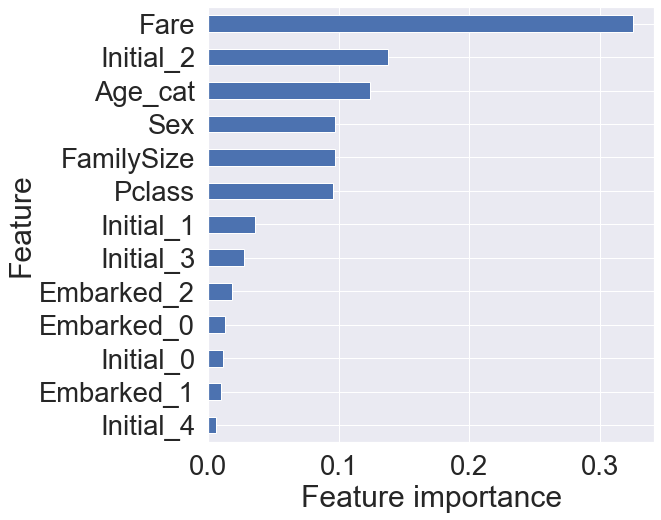

In [131]:
plt.figure(figsize=(8, 8))
Series_feat_imp.sort_values(ascending=True).plot.barh()
plt.xlabel('Feature importance')
plt.ylabel('Feature')

우리가 얻은 모델에서는 Fare 가 가장 큰 영향력을 가지며, 그 뒤로 Initial_2, Age_cat, Pclass가 차례로 중요도를 가집니다

사실 feature importance 는 지금 모델에서의 importance 를 나타냅니다. 만약 다른 모델을 사용하게 된다면 feature importance 가 다르게 나올 수 있습니다.

이 feature importance 를 보고 실제로 Fare 가 중요한 feature 일 수 있다고 판단을 내릴 수는 있지만, 이것은 결국 모델에 귀속되는 하나의 결론이므로 통계적으로 좀 더 살펴보긴 해야합니다.

featuure importance 를 가지고 좀 더 정확도가 높은 모델을 얻기 위해 feature selection 을 할 수도 있고, 좀 더 빠른 모델을 위해 feature 제거를 할 수 있습니다.

## 4.4 Prediction on Test set 

이제 모델이 학습하지 않았던(보지 않았던) 테스트셋을 모델에 주어서, 생존여부를 예측해보겠습니다.

이 결과는 실제로 submission(제출용) 이므로 결과는 leaderboard 에서 확인할 수 있습니다.

캐글에서 준 파일, gender_submission.csv 파일을 읽어서 제출 준비를 하겠습니다.

In [132]:
submission = pd.read_csv('./gender_submission.csv')
submission.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


이제 testset 에 대하여 예측을 하고, 결과를 csv 파일로 저장해보겠습니다.

In [133]:
prediction = model.predict(X_test)
submission['Survived'] = prediction
submission.to_csv('./my_first_submission.csv')